# Chapter7: Moving Beyond Linearity

In [2]:
import pandas as pd
import random
import math
import operator
import numpy as np
import scipy as sc
from IPython.display import display, HTML

In [1]:
# Statsmodel
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table

# Modelling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Evaluation Metric
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

# Regularization
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

# Resampling
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

/Users/ando/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from matplotlib import gridspec

%matplotlib inline
plt.style.use('smandry')

In [4]:
# Extend linear_model.LinearRegression to calculate stats
class LinearRegression(linear_model.LinearRegression):
    def __init__(self,*args,**kwargs):
        """
        Linear Regression with Stats output
        """
        super(LinearRegression,self).__init__(*args,**kwargs)

    def fit_stats(self,X,y):
        """ 
        X is a dataFrame
        
        """
        self.fit(X,y)
        self.params = np.append(self.intercept_,self.coef_)
        predictions = self.predict(X)
        newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True))) 
        n_obs = len(newX)
        n_pred = len(newX.columns)-1        
        RSS = sum((y-predictions)**2)
        mean_y = y.mean()
        TSS = sum((y - mean_y)**2)
        MSE = (RSS)/float(n_obs-n_pred)
        self.MSE = MSE
        variance = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        self.StdErr = np.sqrt(variance)
        self.tValues = self.params/self.StdErr
        self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(len(newX)-1))) for i in self.tValues]
        self.confInt = [self.params-1.95996398*self.StdErr, self.params+1.95996398*self.StdErr]
        self.rsquare = 1.0 - (RSS/TSS)
        self.rsquare_adj = 1.0 -((RSS/TSS)*((n_obs-1)/float(n_obs-n_pred-1)))
        
        myDF3 = pd.DataFrame(index=newX.columns)
        myDF3["Coefs"],myDF3["StdErr"],myDF3["tValues"],myDF3["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
        myDF3["[0.025"] = self.confInt[0]
        myDF3["0.0975]"] = self.confInt[1]
        self.results = myDF3

class var_stat(object):
    def __init__(self, model, X, y, fit=False, linear=True, cols=None):
        if fit:
            model.fit(X,y)
        self.model = model
        n_obs = X.shape[0]
        n_pred = X.shape[1]     
        pred = model.predict(X)
        if isinstance(X, pd.DataFrame):
            newX = np.hstack((np.ones(n_obs).reshape(-1,1), X.values))
            cols = ['Intercept']+list(X.columns)
        else:
            newX = np.hstack((np.ones(n_obs).reshape(-1,1), X))
        self.RSS = self.sum_square(y, pred)
        self.TSS = self.sum_square(y, y.mean())
        self.MSE = self.RSS/float(n_obs-n_pred)
        self.rsquare = 1.0 - (self.RSS/self.TSS)
        self.rsquare_adj = 1.0 -((self.RSS/self.TSS)*((n_obs-1)/float(n_obs-n_pred-1)))
        if linear:
            self.params = np.append(model.intercept_,model.coef_)
            variance = self.MSE * (np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(n_obs-1))) for i in self.tValues]
            self.confInt = [self.params-1.95996398*self.StdErr, self.params+1.95996398*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["tValues"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.975]"] = self.confInt[1]
            self.results = mydf              
    def sum_square(self,y,ypred):
        return sum((y-ypred)**2)

## Loading Wage data

In [5]:
Wage = pd.read_csv('Data/WageR.csv')

In [6]:
Wage.head(2)

,Unnamed: 0,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020


In [337]:
def eval_poly(X,coef):
    poly = PolynomialFeatures(degree=len(coef)-1)
    X_ = poly.fit_transform(X.reshape(-1,1))
    return np.multiply(X_,coef).sum(axis=1)

In [7]:
class var_stat(object):
    def __init__(self, model, X, y, fit=False, linear=True, cols=None):
        if fit:
            model.fit(X,y)
        self.model = model
        n_obs = X.shape[0]
        n_pred = X.shape[1]
        self.n_obs = n_obs
        self.n_pred = n_pred
        self.dof = n_obs - np.linalg.matrix_rank(X)
        pred = model.predict(X)
        if isinstance(X, pd.DataFrame):
            newX = np.hstack((np.ones(n_obs).reshape(-1,1), X.values))
            cols = ['Intercept']+list(X.columns)
        else:
            newX = np.hstack((np.ones(n_obs).reshape(-1,1), X))
        self.copy_X = newX
        self.RSS = self.sum_square(y, pred)
        self.TSS = self.sum_square(y, y.mean())
        self.MSE = self.RSS/float(n_obs-n_pred)
        self.rsquare = 1.0 - (self.RSS/self.TSS)
        self.rsquare_adj = 1.0 -((self.RSS/self.TSS)*((n_obs-1)/float(n_obs-n_pred-1)))
        if linear:
            self.params = np.append(model.intercept_,model.coef_)
            self.cov_params = self.MSE * np.linalg.pinv(np.dot(newX.T,newX))
            variance = self.cov_params.diagonal() 
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(self.dof))) for i in self.tValues]
            self.confInt = [self.params-1.95996398*self.StdErr, self.params+1.95996398*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["tValues"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.0975]"] = self.confInt[1]
            self.results = mydf
    def sum_square(self, y, ypred):
        return sum((y-ypred)**2)

    def confidence_band(self, xnew, alpha=0.05):
        pred = self.model.predict(xnew[:,1:])
        predvar = self.MSE + (xnew * np.dot(self.cov_params, xnew.T).T).sum(1)
        predstd = np.sqrt(predvar)
        tppf = sc.stats.t.isf(alpha/2., self.dof)
        interval_u = pred + tppf * predstd
        interval_l = pred - tppf * predstd
        return predstd, interval_l, interval_u
    
    def confidence_mean(self, xnew, alpha=0.05):
        X0 = self.copy_X
        cov_matrix = np.linalg.pinv(np.dot(X0.T, X0))
        last_term = np.dot(cov_matrix, xnew.T)
        #pred_mean_se = np.sqrt(((xnew * np.dot(self.cov_params, xnew.T).T).sum(1)))
        pred_mean_se = np.sqrt(self.MSE * (xnew * last_term.T).sum(1))
        tppf = sc.stats.t.isf(alpha/2.0, self.dof)
        mean_u = pred + tppf * pred_mean_se
        mean_l = pred - tppf * pred_mean_se
        return pred_mean_se, mean_u, mean_l
        # http://www.stats.uwo.ca/faculty/braun/ss3859/notes/Chapter4/ch4.pdf
        #sx = (xnew - mean_x),2)
        #confs = t * self.MSE*np.sqrt(1.0/n + /((np.sum(np.power(x,2)))-n*(np.power(mean_x,2)))))


In [221]:
# from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(Wage[['age']])
age_grid = np.linspace(Wage.age.min(), Wage.age.max(),150) 
age_grid_poly = poly.fit_transform(age_grid.reshape(-1,1))

reg = linear_model.LinearRegression()
reg.fit(X_poly, Wage.wage)
pred = reg.predict(age_grid_poly)
stats = var_stat(reg,X_poly[:,1:], Wage.wage,  fit=True)
meanse, mean_u, mean_l = stats.confidence_mean(age_grid_poly)

# Logistic regression : Use larger C to turn off regularisation
wage_binary = (Wage.wage > 250).map({False:0, True:1}).as_matrix()
logit_model = linear_model.LogisticRegression(C=1.e9, solver='newton-cg', max_iter=10000)

# MinMaxscaling to get the same result as the book
scaler= preprocessing.MinMaxScaler()
age_scale = scaler.fit_transform(X_poly[:,1:])
logit_model.fit(age_scale, wage_binary)
pred_bin_sk = logit_model.predict_proba(scaler.fit_transform(age_grid_poly[:,1:]))

# for comparison result: Use statmodels  
clf = sm.GLM(wage_binary, X_poly , family=sm.families.Binomial(sm.families.links.logit), alpha=0)
ress = clf.fit()
pred_bin = ress.predict(age_grid_poly)

The author of ISL use the formula in python
```python
proba = np.exp(np.dot(x, params)) / (1 + np.exp(np.dot(x, params)))
```
and calculate confidence interval for the linear part, and then transform with the logit function.

In [655]:
# Logistic regression standard error : https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients/89520
# confidence interval: https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode
def std_err(X, proba, params, alpha=0.05):
    V = np.matrix(np.zeros(shape = (X.shape[0], X.shape[0])))
    np.fill_diagonal(V, np.multiply(1-proba, proba))
    # Covariance matrix
    covLogit = np.linalg.inv(np.dot(X_poly.T, V).dot(X_poly))
    # Standard errors
    stderr = np.sqrt(np.diag(covLogit))
    gradient = (proba * (1 - proba) * X.T).T
    std_errors = np.sqrt(np.multiply((np.dot(gradient, covLogit)) , gradient).sum(1))
    c = sc.stats.t.isf(alpha/2.0, X.shape[0] - X.shape[1])
    upper = np.maximum(0, np.minimum(1, proba + std_errors.A1 * c))
    lower = np.maximum(0, np.minimum(1, proba - std_errors.A1 * c))
    
    # in the ISLR book use result
    lin_result = np.dot(X, params)
    std_errors_xb = np.sqrt(np.multiply((np.dot(X, covLogit)) , X).sum(1))
    upper_xb = lin_result + (c * std_errors_xb.A1)
    lower_xb = lin_result - (c * std_errors_xb.A1)
    # plug result to the probability equations
    upper_book = np.exp(upper_xb) / (1.0 + np.exp(upper_xb))
    lower_book = np.exp(lower_xb) / (1.0 + np.exp(lower_xb))
    return stderr, upper, lower, upper_book, lower_book


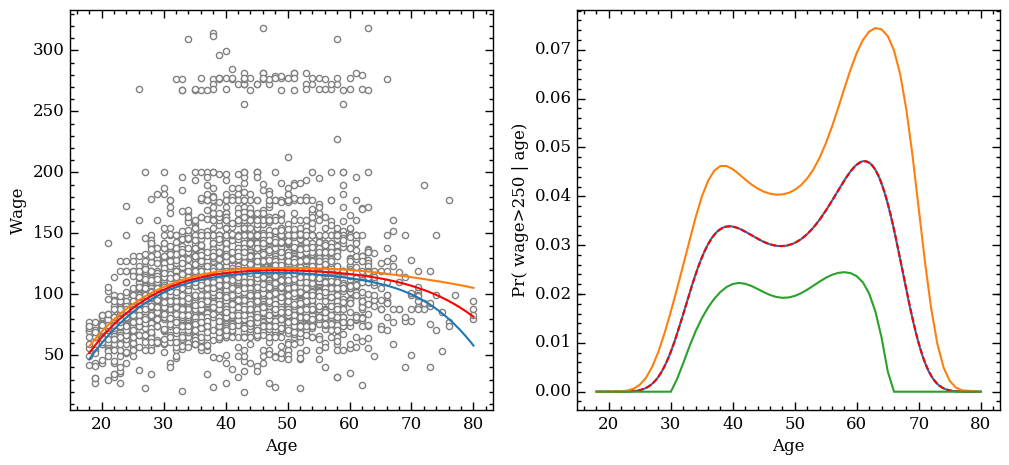

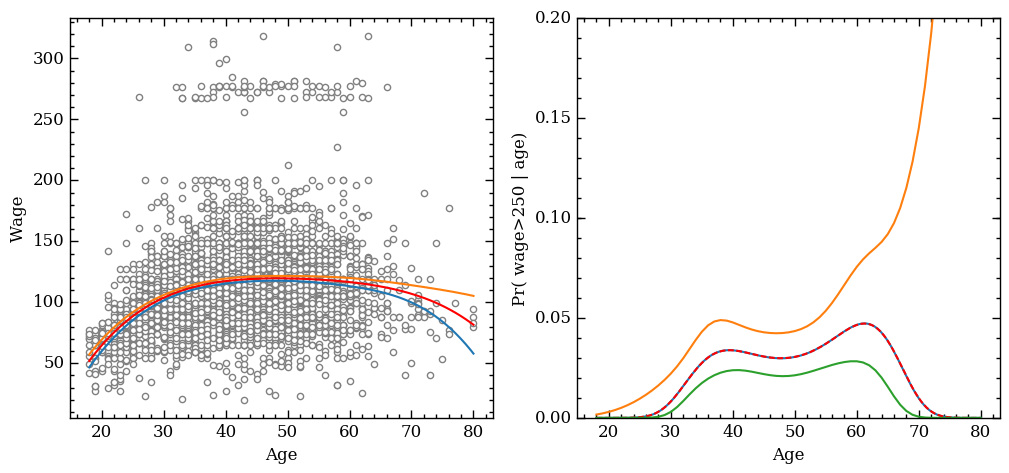

In [658]:
# Run confidence band
proba = ress.predict(X_poly)
stderr, upper, lower, upper_book, lower_book  = std_err(X_poly, proba, ress.params)
# Plot
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))
ax1.scatter(Wage.age,Wage.wage, Facecolors='w', edgecolors='Grey')
ax1.plot(age_grid, pred, color='r')
ax1.plot(age_grid, mean_l)
ax1.plot(age_grid, mean_u)
ax1.set_xlabel('Age')
ax1.set_ylabel('Wage')

ax2.plot(age_grid, pred_bin)
ax2.plot(age_grid, pred_bin_sk[:,1], color='r', ls='--')
indsort = Wage.age.argsort()
ax2.plot(Wage.age[indsort], upper[indsort])
ax2.plot(Wage.age[indsort], lower[indsort])
ax2.set_xlabel('Age')
ax2.set_ylabel('Pr( wage>250 | age)')
plt.show()

# The plot in the book : Figure 7.1

fig,(ax3,ax4)=plt.subplots(ncols=2,figsize=(12,5))
ax3.scatter(Wage.age,Wage.wage, Facecolors='w', edgecolors='Grey')
ax3.plot(age_grid, pred, color='r')
ax3.plot(age_grid, mean_l)
ax3.plot(age_grid, mean_u)
ax3.set_xlabel('Age')
ax3.set_ylabel('Wage')
ax4.plot(age_grid, pred_bin)
ax4.plot(age_grid, pred_bin_sk[:,1], color='r', ls='--')
indsort = Wage.age.argsort()
ax4.plot(Wage.age[indsort], upper_book[indsort])
ax4.plot(Wage.age[indsort], lower_book[indsort])
ax4.set_xlabel('Age')
ax4.set_ylabel('Pr( wage>250 | age)');
ax4.set_ylim([0,0.2])
plt.show()


In [214]:
ress.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-109.5530,47.655,-2.299,0.022,-202.956,-16.150
x1,8.9950,4.187,2.148,0.032,0.789,17.201
x2,-0.2816,0.135,-2.081,0.037,-0.547,-0.016
x3,0.0039,0.002,2.022,0.043,0.000,0.008
x4,-1.949e-05,9.91e-06,-1.966,0.049,-3.89e-05,-6.41e-08


In [625]:
# Logistic regression standard error : https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients/89520
# confidence interval: https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode
def std_err(model, X, alpha=0.05):
    proba = model.predict(X)
    V = np.matrix(np.zeros(shape = (X.shape[0], X.shape[0])))
    np.fill_diagonal(V, np.multiply(1-proba, proba))
    # Covariance matrix
    covLogit = np.linalg.inv(np.dot(X_poly.T, V).dot(X_poly))
    # Standard errors
    stderr = np.sqrt(np.diag(covLogit))
    gradient = (proba * (1 - proba) * X.T).T
    std_errors = np.sqrt(np.multiply((np.dot(gradient, covLogit)) , gradient).sum(1))
    c = sc.stats.t.isf(alpha/2.0, X.shape[0] - X.shape[1])
    upper = np.maximum(0, np.minimum(1, proba + std_errors.A1 * c))
    lower = np.maximum(0, np.minimum(1, proba - std_errors.A1 * c))
    return stderr, upper, lower


In [115]:
regf = LinearRegression()
regf.fit_stats(Wage[['age','year']],Wage.wage)

In [353]:
res = sm.OLS(Wage.wage, X_poly).fit()
from statsmodels.stats.outliers_influence import summary_table
st, data, ss2 = summary_table(res, alpha=0.05)

In [446]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Fri, 04 May 2018   Prob (F-statistic):           2.77e-57
Time:                        16:11:22   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.002    -301.879     -66.430
x1            21.2455      5.887      3.609      0.000       9.703      32.788
x2            -0.5639      0.206     -2.736      0.006      -0.968      -0.160
x3             0.0068      0.003      2.221      0.026       0.001       0.013
x4         -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [438]:
res.cov_params()

,const,x1,x2,x3,x4
const,3604.846892,-351.223017,12.102697,-1.759690e-01,9.158120e-04
x1,-351.223017,34.653805,-1.207207,1.771806e-02,-9.296448e-05
x2,12.102697,-1.207207,0.042481,-6.291981e-04,3.328488e-06
x3,-0.175969,0.017718,-0.000629,9.399934e-06,-5.012724e-08
x4,0.000916,-0.000093,0.000003,-5.012724e-08,2.694059e-10


In [451]:
pd.DataFrame(res.mse_resid * np.linalg.inv(np.dot(X_poly.T, X_poly)))

,0,1,2,3,4
0,3604.846892,-351.223017,12.102697,-1.759690e-01,9.158120e-04
1,-351.223017,34.653805,-1.207207,1.771806e-02,-9.296448e-05
2,12.102697,-1.207207,0.042481,-6.291981e-04,3.328488e-06
3,-0.175969,0.017718,-0.000629,9.399934e-06,-5.012724e-08
4,0.000916,-0.000093,0.000003,-5.012724e-08,2.694059e-10


In [355]:
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

In [357]:
predict_mean_ci_low

array([  41.54283705,   80.89704971,  117.15399816, ...,   92.48402535,
         92.48402535,  116.09618232])

In [361]:
print res.conf_int(0.05)

                0             1
const -301.878732 -6.642963e+01
x1       9.703041  3.278800e+01
x2      -0.967987 -1.597312e-01
x3       0.000799  1.282223e-02
x4      -0.000064  1.447431e-07


In [360]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [476]:
bbbb = summary_table(res)

In [479]:
st, data, ss2 = summary_table(res, alpha=0.05)
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

In [860]:
#zip(predict_mean_ci_low, mean_l)

In [936]:
#zip(predict_mean_se, meanse)

In [941]:
class var_stat(object):
    def __init__(self, model, X, y, fit=False, linear=True, cols=None):
        if fit:
            model.fit(X,y)
        self.model = model
        n_obs = X.shape[0]
        n_pred = X.shape[1]
        self.n_obs = n_obs
        self.n_pred = n_pred
        self.dof = n_obs - np.linalg.matrix_rank(X)
        pred = model.predict(X)
        if isinstance(X, pd.DataFrame):
            newX = np.hstack((np.ones(n_obs).reshape(-1,1), X.values))
            cols = ['Intercept']+list(X.columns)
        else:
            newX = np.hstack((np.ones(n_obs).reshape(-1,1), X))
        self.copy_X = newX
        self.RSS = self.sum_square(y, pred)
        self.TSS = self.sum_square(y, y.mean())
        self.MSE = self.RSS/float(n_obs-n_pred)
        self.rsquare = 1.0 - (self.RSS/self.TSS)
        self.rsquare_adj = 1.0 -((self.RSS/self.TSS)*((n_obs-1)/float(n_obs-n_pred-1)))
        if linear:
            self.params = np.append(model.intercept_,model.coef_)
            self.cov_params = self.MSE * np.linalg.pinv(np.dot(newX.T,newX))
            variance = self.cov_params.diagonal() 
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(self.dof))) for i in self.tValues]
            self.confInt = [self.params-1.95996398*self.StdErr, self.params+1.95996398*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["tValues"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.0975]"] = self.confInt[1]
            self.results = mydf
    def sum_square(self, y, ypred):
        return sum((y-ypred)**2)

    def confidence_band(self, xnew, alpha=0.05):
        pred = self.model.predict(xnew[:,1:])
        predvar = self.MSE + (xnew * np.dot(self.cov_params, xnew.T).T).sum(1)
        predstd = np.sqrt(predvar)
        tppf = sc.stats.t.isf(alpha/2., self.dof)
        interval_u = pred + tppf * predstd
        interval_l = pred - tppf * predstd
        return predstd, interval_l, interval_u
    
    def confidence_mean(self, xnew, alpha=0.05):
        X0 = self.copy_X
        cov_matrix = np.linalg.pinv(np.dot(X0.T, X0))
        last_term = np.dot(cov_matrix, xnew.T)
        #pred_mean_se = np.sqrt(((xnew * np.dot(self.cov_params, xnew.T).T).sum(1)))
        pred_mean_se = np.sqrt(self.MSE * (xnew * last_term.T).sum(1))
        tppf = sc.stats.t.isf(alpha/2.0, self.dof)
        mean_u = pred + tppf * pred_mean_se
        mean_l = pred - tppf * pred_mean_se
        return pred_mean_se, mean_u, mean_l
        # http://www.stats.uwo.ca/faculty/braun/ss3859/notes/Chapter4/ch4.pdf
        #sx = (xnew - mean_x),2)
        #confs = t * self.MSE*np.sqrt(1.0/n + /((np.sum(np.power(x,2)))-n*(np.power(mean_x,2)))))



In [942]:
bb = var_stat(reg,X_poly[:,1:],Wage.wage,  fit=True)

In [487]:
predvar, low_end, high_end = bb.confidence_band(poly.fit_transform(poly_array.reshape(-1,1)))

In [943]:
meanse, mean_u, mean_l = bb.confidence_mean(poly.fit_transform(poly_array.reshape(-1,1)))

In [932]:
meanse, mean_u, mean_l = bb.confidence_mean(X_poly)

In [559]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [186]:
reg = linear_model.LinearRegression()
reg.fit(Wage[['age','year']],Wage.wage)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [91]:
regfit3 = smf.ols('wage ~ age + year', Wage).fit()


In [593]:
def pinv_extended(X, rcond=1e-15):
    """
    Return the pinv of an array X as well as the singular values
    used in computation.

    Code adapted from numpy.
    """
    X = np.asarray(X)
    X = X.conjugate()
    u, s, vt = np.linalg.svd(X, 0)
    s_orig = np.copy(s)
    m = u.shape[0]
    n = vt.shape[1]
    cutoff = rcond * np.maximum.reduce(s)
    for i in range(min(n, m)):
        if s[i] > cutoff:
            s[i] = 1./s[i]
        else:
            s[i] = 0.
    res = np.dot(np.transpose(vt), np.multiply(s[:, np.core.newaxis],
                                               np.transpose(u)))
    return res, s_orig    

In [397]:
def covar(X):
    X = X.T
    X0 = X - X.mean(axis=0)
    return np.dot(X0.T,X0)/float(X.shape[0]-1)
covar(X.T)

array([[ 4.,  4.],
       [ 4.,  4.]])

In [411]:
scaler = preprocessing.StandardScaler()
X_polyv = scaler.fit_transform(X_poly)

In [415]:
X_polyv

array([[ 1.        , -2.11556738, -1.58888784, -1.21239275, -0.94303812],
       [ 1.        , -1.59565841, -1.33991193, -1.10184062, -0.89706997],
       [ 1.        ,  0.224023  ,  0.09169954, -0.0325476 , -0.13319416],
       ..., 
       [ 1.        , -1.33570392, -1.18874799, -1.02079396, -0.85660157],
       [ 1.        , -1.33570392, -1.18874799, -1.02079396, -0.85660157],
       [ 1.        ,  1.09053796,  1.07969918,  1.00837426,  0.89034719]])

In [437]:
newX = X_poly
XtX_inv = np.linalg.pinv(np.dot(newX.T,newX))
y = Wage.wage.values
newXt = newX.T
bbb = np.dot(newXt,y)
np.dot(XtX_inv, bbb)

array([  3.18455803e-01,   3.27006132e+00,   5.56168553e-02,
        -2.19710003e-03,   1.48455019e-05])

In [404]:
bb = var_stat(reg,X_poly[:,1:],Wage.wage,  fit=True)

In [405]:
bb.results

,Coefs,StdErr,tValues,pValue,[0.025,0.975]
0,-184.154180,0.063711,-2890.456417,0.000000e+00,-184.279051,-184.029308
1,21.245521,0.652374,32.566465,0.000000e+00,19.966891,22.524150
2,-0.563859,0.042766,-13.184636,0.000000e+00,-0.647680,-0.480039
3,0.006811,0.000897,7.593674,4.130030e-14,0.005053,0.008569
4,-0.000032,0.000006,-5.299535,1.245090e-07,-0.000044,-0.000020


In [429]:
regv = linear_model.LinearRegression()
regv.fit(X_poly,Wage.wage)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [432]:
regv.intercept_ , regv.coef_

(-184.15417973466867,
 array([  0.00000000e+00,   2.12455205e+01,  -5.63859312e-01,
          6.81068771e-03,  -3.20383038e-05]))

In [770]:
xx = np.asarray([[1,0.6,200], [1,0.6,250], [1,0.6,400], [1,0.6,500], [1,0.6,600], [1,1.0,200], [1,1.0,250], [1,1.0,400], [1,1.0,500], [1,1.0,600], [1,2.6,200], [1,2.6,250], [1,2.6,400], [1,2.6,500], [1,2.6,600], [1,2.8,200], [1,2.8,250], [1,2.8,400], [1,2.8,500], [1,2.8,600]])
yy = np.asarray([90.6, 82.7, 58.7, 43.2, 25.0, 127.1, 112.3, 19.6, 17.8, 9.1, 53.1, 52.0, 43.4, 42.4, 31.6, 40.9, 37.9, 27.5, 27.3, 19.0])

In [803]:
# coefficient
coef = np.dot(np.linalg.inv(np.dot(xx.T,xx)), np.dot(xx.T, yy))

In [804]:
# predicted
pred = np.dot(xx, coef)

In [819]:
# Mean square error
MSE = ((yy - pred)**2).sum()/float(len(xx)-xx.shape[1])

In [824]:
# covariance matrix of the estimated coeff
cov_params = MSE * np.linalg.inv(np.dot(xx.T,xx))
cov_params

array([[  2.46870216e+02,  -4.19933390e+01,  -3.87501034e-01],
       [ -4.19933390e+01,   2.39961937e+01,  -1.45693662e-16],
       [ -3.87501034e-01,  -0.00000000e+00,   9.93592396e-04]])

In [ ]:
co

In [796]:
gg = linear_model.LinearRegression()
gg.fit(xx,yy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [801]:
gg.predict(xx)

array([ 88.85655113,  81.55152881,  59.63646184,  45.0264172 ,
        30.41637256,  84.32178024,  77.01675792,  55.10169095,
        40.49164631,  25.88160167,  66.18269668,  58.87767436,
        36.9626074 ,  22.35256275,   7.74251811,  63.91531124,
        56.61028892,  34.69522195,  20.08517731,   5.47513267])

In [10]:
from sklearn.preprocessing import PolynomialFeatures